# Load and Prepare Data Sets

In [14]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# freMTPL2freq data set
#   1. load it from from https://www.openml.org/d/41214 
#   2. change IDpol format to INT and set it as index for df_freq
#   3. Correct for unreasonable observations (that might be data error)
#       3.1 cut the ClaimNb to a maximum of 4
#       3.2 cut the Exposure to a maximum of 1

df_freq = fetch_openml(data_id=41214, as_frame=True)["data"]

df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_freq.set_index("IDpol", inplace=True)

df_freq["ClaimNb"] = df_freq["ClaimNb"].clip(upper=4)
df_freq["Exposure"] = df_freq["Exposure"].clip(upper=1)


# freMTPL2sev data set
#   1. load it from from https://www.openml.org/d/41215
#   2. Correct for unreasonable observations (that might be data error)
#       2.1 cut the ClaimAmount to a maximum of 100000. For the largest claims, extreme value theory might apply. 
#           100'000 is the 0.9984 quantile, claims larger than this limit account for 25% of the overall claim amount. 
#           This is a well known phenomenon for third-party liability.

df_sev = fetch_openml(data_id=41215, as_frame=True)["data"]

df_sev['ClaimAmount'] = df_sev['ClaimAmount'].clip(upper=100000)


In [3]:
for df in [df_freq, df_sev]:
    display(df.head())
    display(df.dtypes)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
IDpol,,,,,,,,,,,
1,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
3,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
5,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
10,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
11,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


ClaimNb        float64
Exposure       float64
Area          category
VehPower       float64
VehAge         float64
DrivAge        float64
BonusMalus     float64
VehBrand      category
VehGas          object
Density        float64
Region        category
dtype: object

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


IDpol          float64
ClaimAmount    float64
dtype: object

In [4]:
# create df by joining df_freq to df_sev:
#   1. aggregate ClaimAmount per IDpol for df_sev
#   2. join by IDpol
#   3. fill null value by zero
#   4. filter out claims with zero amount, as the severity model requires strictly positive target values (9116 zero claims).
#   5. define column PurePremium: the expected total claim amount per unit of exposure for each policyholder
#   6. define column Frequency and AvgClaimAmount

df_sev = df_sev.groupby("IDpol").sum()

df = df_freq.join(df_sev, how="left")

df["ClaimAmount"].fillna(0, inplace=True)

df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

df.to_csv('processed_data/sev_freq_joined_cliped.csv')

display(df.head())

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
1.0,0.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,0.0,0.0
3.0,0.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,0.0,0.0
5.0,0.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0,0.0,0.0
10.0,0.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,0.0,0.0
11.0,0.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,0.0,0.0


# Expolatory Data Analysis

In [5]:
display(df.describe().round(2))
display(df.describe(include=[object, 'category']))

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
count,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00
mean,0.04,0.53,6.45,7.04,45.50,59.76,1792.42,72.72,309.06,0.12,67.78
std,0.21,0.36,2.05,5.67,14.14,15.64,3958.65,1171.68,18064.76,2.01,1085.24
min,0.00,0.00,4.00,0.00,18.00,50.00,1.00,0.00,0.00,0.00,0.00
25%,0.00,0.18,5.00,2.00,34.00,50.00,92.00,0.00,0.00,0.00,0.00
50%,0.00,0.49,6.00,6.00,44.00,50.00,393.00,0.00,0.00,0.00,0.00
75%,0.00,0.99,7.00,11.00,55.00,64.00,1658.00,0.00,0.00,0.00,0.00
max,4.00,1.00,15.00,100.00,100.00,230.00,27000.00,115600.00,10000000.00,365.00,100000.00


,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,C,B12,Regular,R24
freq,191880,166024,345877,160601


In [6]:
policies_no_claims = len(df.loc[df['ClaimNb'] == 0].index)
all_policies = len(df.index)

pct_pols_no_clm = round((policies_no_claims/all_policies)*100, 2) 

print(str(pct_pols_no_clm)+"% of policyholders have not made any claims.")

96.32% of policyholders have not made any claims.


Text(0.5, 0.98, 'Targets histogram (log of non-zero values)')

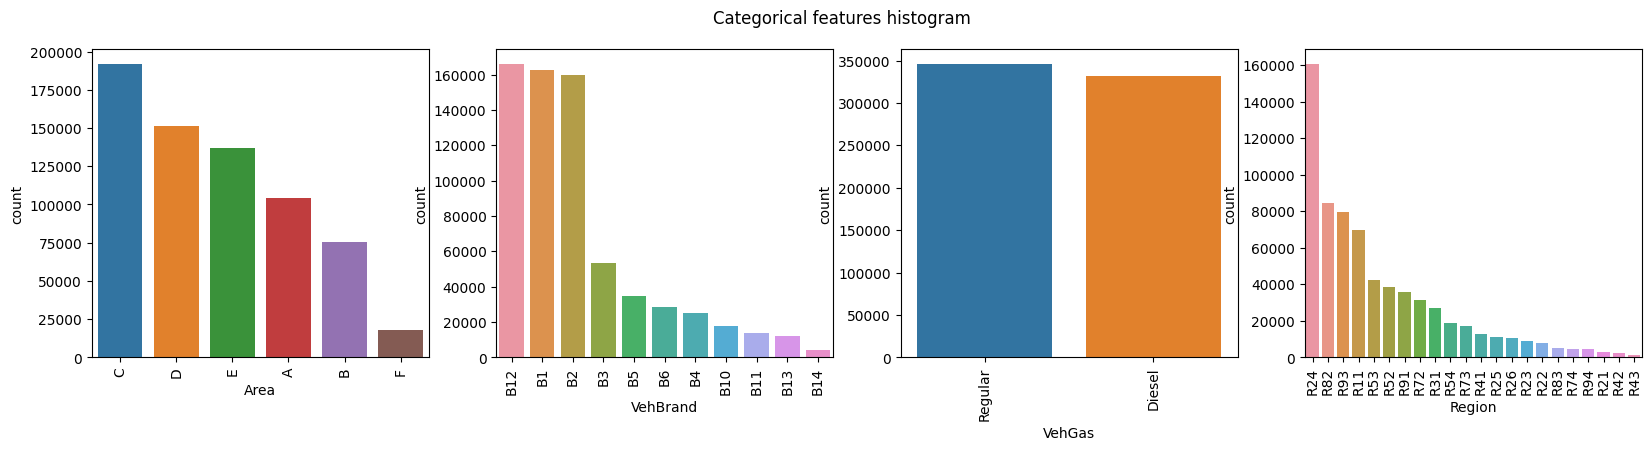

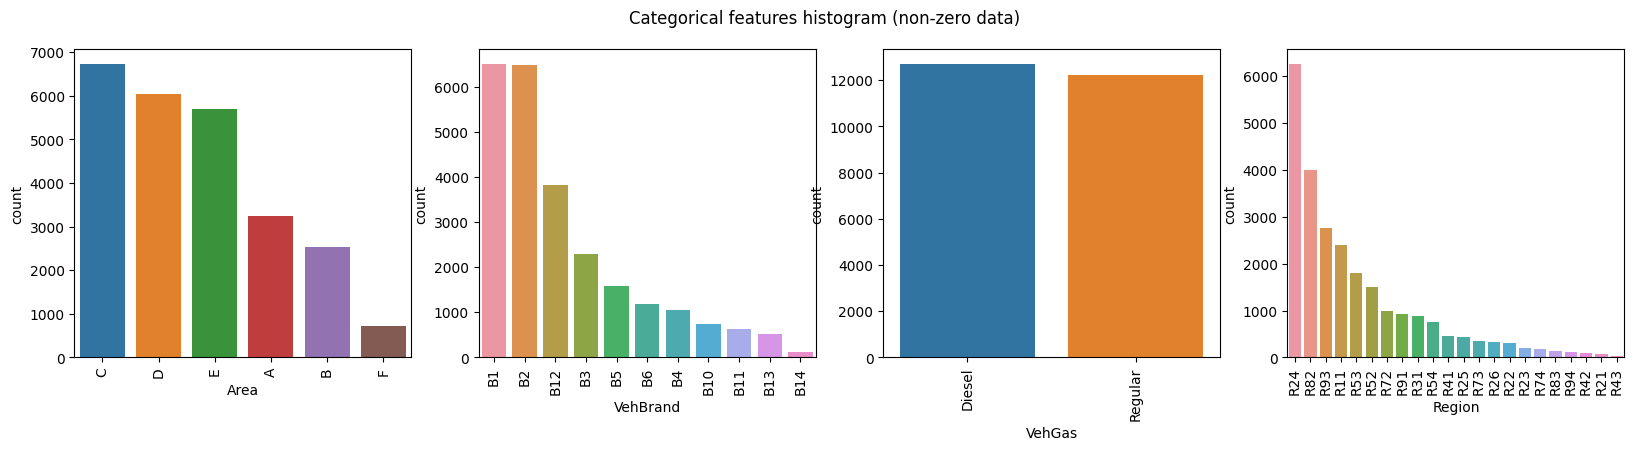

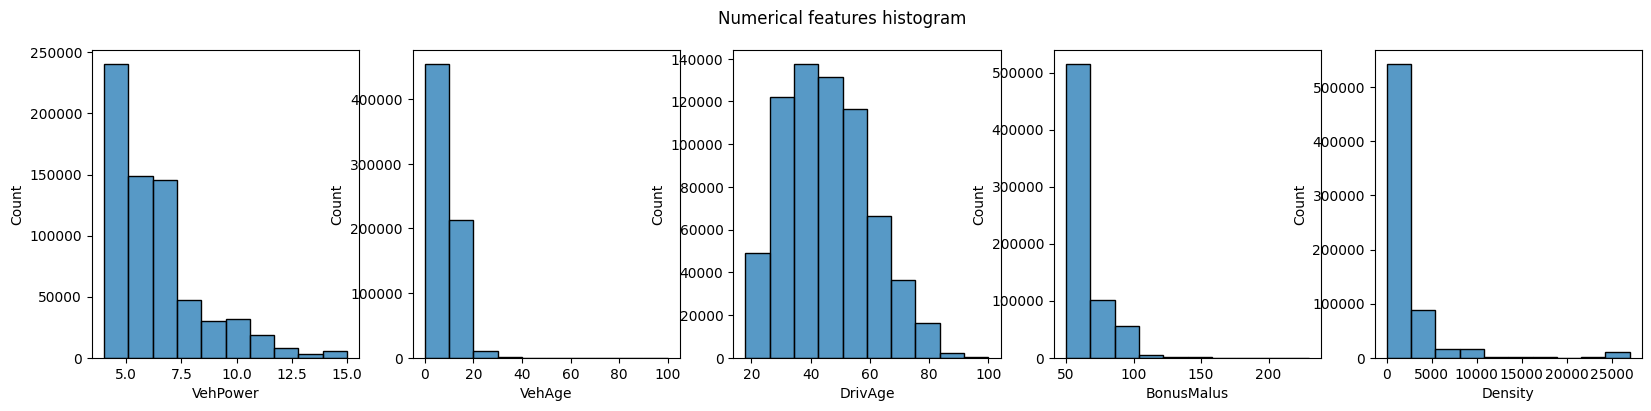

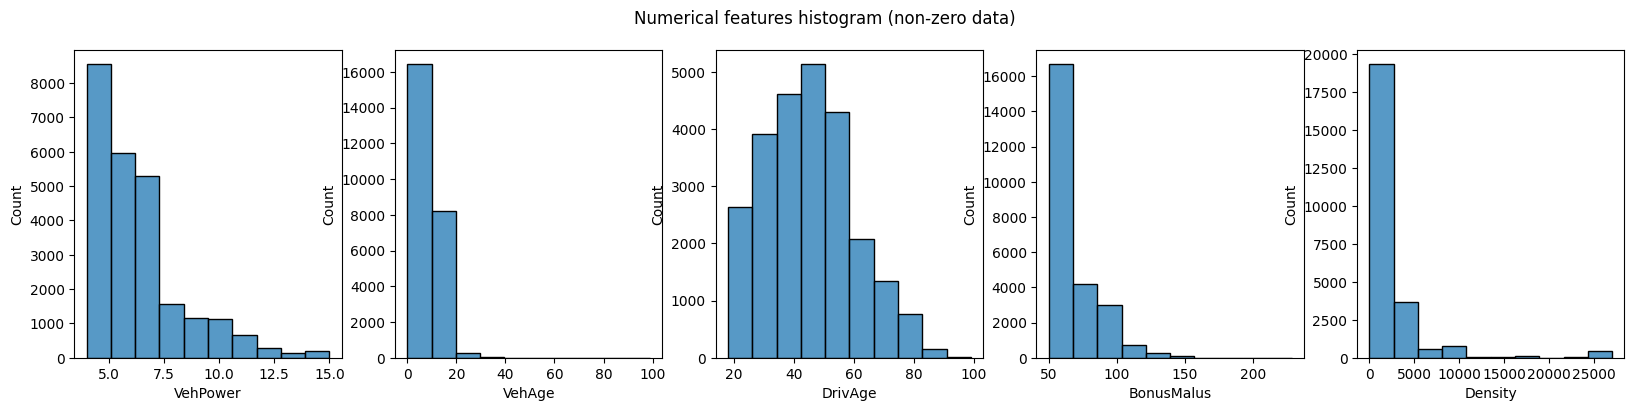

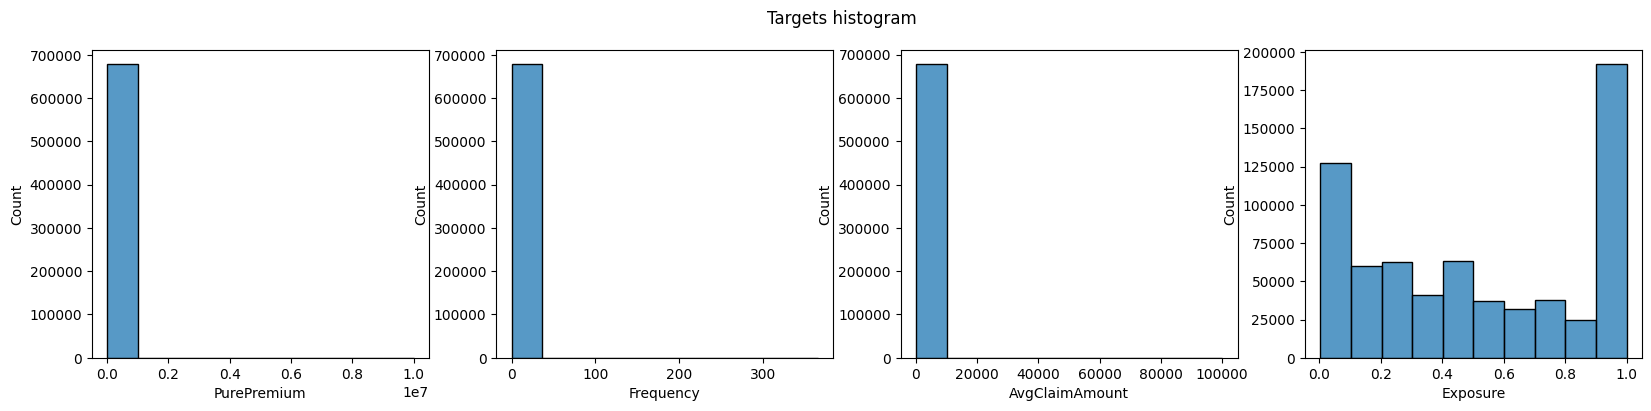

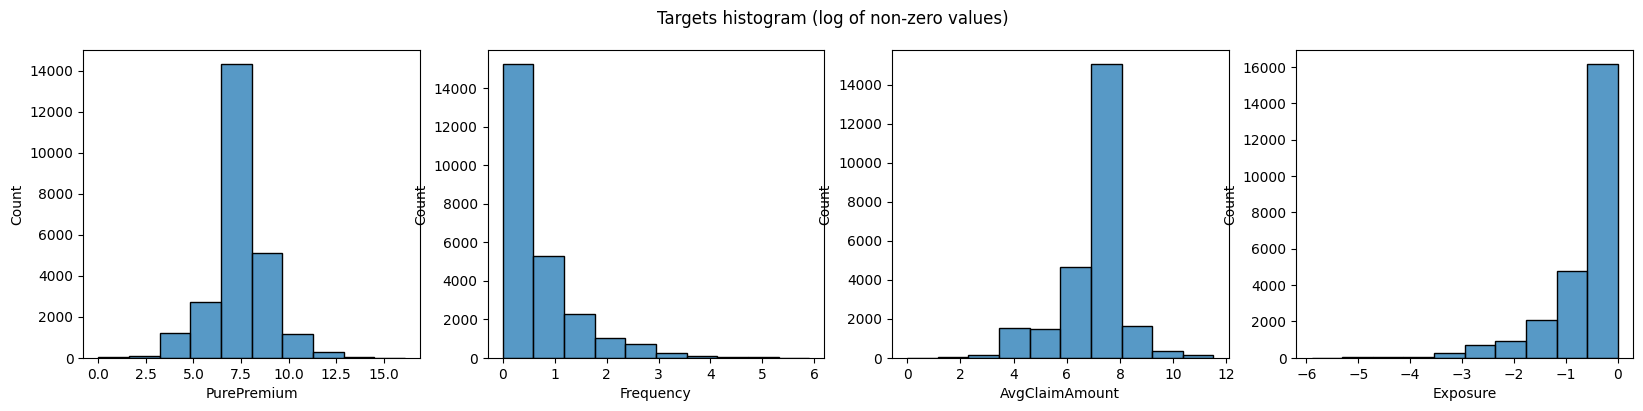

In [7]:
# Plot the histogram
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 


cat_variables = ['Area', 'VehBrand', 'VehGas', 'Region']
num_variables = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
tar_variables = ['PurePremium', 'Frequency', 'AvgClaimAmount', 'Exposure']
df_nonzero = df[df.ClaimAmount != 0]


# for categorical features
fig, axes = plt.subplots(1,4, figsize=(20,4))
for i, j in enumerate(cat_variables):
    sns.countplot(data=df, x=j, ax=axes[i], order=df[j].value_counts().index)
    axes[i].tick_params(axis='x', labelrotation=90)
fig.suptitle('Categorical features histogram', fontsize=12)

# for categorical features non-zero data
fig, axes = plt.subplots(1,4, figsize=(20,4))
for i, j in enumerate(cat_variables):
    sns.countplot(data=df_nonzero, x=j, ax=axes[i], order=df_nonzero[j].value_counts().index)
    axes[i].tick_params(axis='x', labelrotation=90)
fig.suptitle('Categorical features histogram (non-zero data)', fontsize=12)

# for numerical features
fig, axes = plt.subplots(1,5, figsize=(20,4))
for i, j in enumerate(num_variables):
    sns.histplot(df[j], ax=axes[i], bins=10)
fig.suptitle('Numerical features histogram', fontsize=12)

# for numerical features non-zero data
fig, axes = plt.subplots(1,5, figsize=(20,4))
for i, j in enumerate(num_variables):
    sns.histplot(df_nonzero[j], ax=axes[i], bins=10)
fig.suptitle('Numerical features histogram (non-zero data)', fontsize=12)

# for target values
fig, axes = plt.subplots(1,4, figsize=(20,4))
for i, j in enumerate(tar_variables):
    sns.histplot(df[j], ax=axes[i], bins=10)
fig.suptitle('Targets histogram', fontsize=12)

# for log(non-zero target) values
fig, axes = plt.subplots(1,4, figsize=(20,4))
for i, j in enumerate(tar_variables):
    sns.histplot(np.log(df_nonzero[j]), ax=axes[i], bins=10)
fig.suptitle('Targets histogram (log of non-zero values)', fontsize=12)


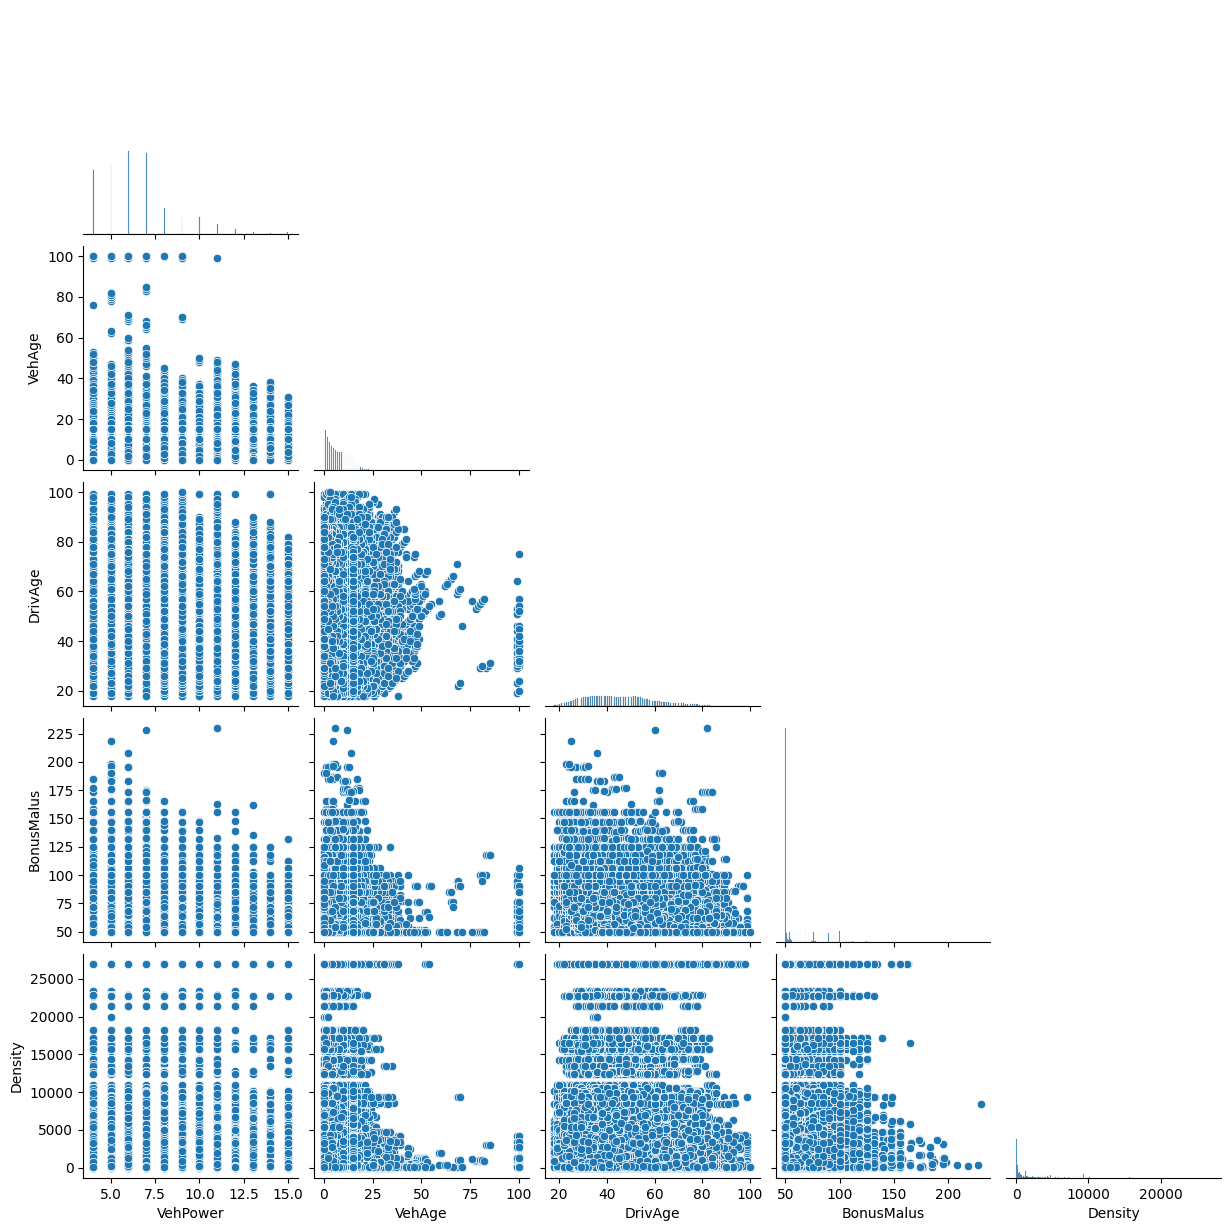

In [9]:
sns.pairplot(df[['Area','VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']], 
             corner=True)


In [12]:
# feature linear correlation 
display(df[['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']].corr())

,VehPower,VehAge,DrivAge,BonusMalus,Density
VehPower,1.000000,-0.006001,0.030108,-0.075895,0.042901
VehAge,-0.006001,1.000000,-0.059213,0.079923,-0.090428
DrivAge,0.030108,-0.059213,1.000000,-0.479966,-0.004700
BonusMalus,-0.075895,0.079923,-0.479966,1.000000,0.077717
Density,0.042901,-0.090428,-0.004700,0.077717,1.000000
